In [1]:
from mikagrad.engine import Value
from mikagrad.visualization import draw_dot

An autograd engine tracks your computations to simplify the propagation of gradients for updating a model's weights

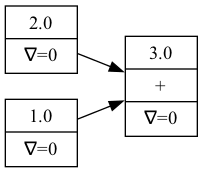

In [2]:
a = Value(1.0)
b = Value(2.0)
c = a + b

draw_dot(c)

The gradients are currently unfilled, as we haven't called the `backward()` method yet to initiate backpropagation. Let's do that now:

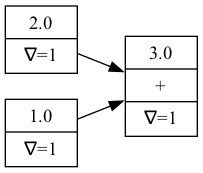

In [3]:
c.backward()
draw_dot(c)

We can see here that the gradients both populated to 1.0, let's check if that's right:
$$ c = a + b $$
$$ \frac{\partial c}{\partial a} = 1.0 \qquad \frac{\partial c}{\partial a} = 1.0 $$
Alright its correct. Let's try a more involved example:

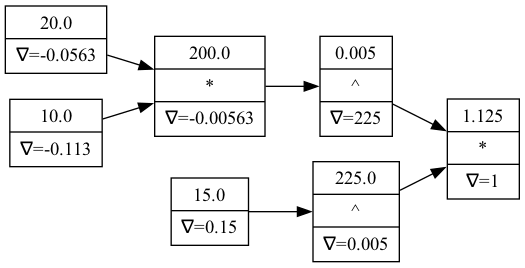

In [4]:
a = Value(10)
b = Value(20)
c = Value(15)
d = a * b
e = c**2
f = e / d
f.backward()
draw_dot(f)

$$ \frac{\partial f}{\partial f} = 1 $$

$$ f = \frac{e}{d} : \qquad \qquad \frac{\partial f}{\partial e} = \frac{1}{d} = \frac{1}{200} = 0.005 \qquad \frac{\partial f}{\partial d} = -\frac{e}{d^2} = -\frac{225}{40 000} = -0.005625 $$

$$ e = c^2 : \qquad \qquad \frac{\partial f}{\partial c} = \frac{\partial f}{\partial e}\frac{\partial e}{\partial c} = 0.005 \times 2c = 0.15 $$

$$ d = a \times b : \qquad \qquad \frac{\partial f}{\partial a} = \frac{\partial f}{\partial d}\frac{\partial d}{\partial a} = -0.005625 b = -0.1125 \qquad \frac{\partial f}{\partial b} = \frac{\partial f}{\partial d}\frac{\partial d}{\partial b} = -0.005625 a = -0.05625 $$

Although the computation graph shows some intermediate steps which we have skipped in our computation, we can clearly see that we get exactly the same gradient values as displayed above.

A key behaviour of this autograd engine is that is supports arbitrary tensor operations. This means we can propagate gradients based on complex matrix multiplications or across broadcasted dimensions. Since it supports all necessary elementary operations and activation functions, this engine can easily be used in machine learning applications like neural networks. For this reason, I have also built out a neural network library on top of the engine:

In [5]:
from mikagrad.nn import MLP
import numpy as np

xs = np.array([
    [0.0, 0.0],
    [0.0, 1.0],
    [1.0, 0.0],
    [1.0, 1.0],
])

ys = np.array([0.0, 1.0, 1.0, 0.0])

model = MLP(num_in=2, num_outs=[4, 4, 1])

# Training loop
lr = 0.1 # learning rate
for epoch in range(1000):
    # forward pass
    preds = [model(x) for x in xs]
    losses = [(p - y) ** 2 for p, y in zip(preds, ys)]
    loss = sum(losses) / len(losses)

    # backward pass
    model.zero_grad()
    loss.backward()

    # parameter update
    for param in model.parameters():
        param.data -= lr * param.grad

    # logging
    if epoch % 100 == 0:
        print(f"epoch {epoch:4d}   loss = {loss.data.item():.8f}")

# Evaluate
print("\nAfter training:")
for x, y_true in zip(xs, ys):
    y_pred = model(x).data
    print(f"x = {x}  →  ŷ = {float(y_pred):.3f}   (target {y_true})")

epoch    0   loss = 0.36749954
epoch  100   loss = 0.00445360
epoch  200   loss = 0.00001969
epoch  300   loss = 0.00000004
epoch  400   loss = 0.00000000
epoch  500   loss = 0.00000000
epoch  600   loss = 0.00000000
epoch  700   loss = 0.00000000
epoch  800   loss = 0.00000000
epoch  900   loss = 0.00000000

After training:
x = [0. 0.]  →  ŷ = 0.000   (target 0.0)
x = [0. 1.]  →  ŷ = 1.000   (target 1.0)
x = [1. 0.]  →  ŷ = 1.000   (target 1.0)
x = [1. 1.]  →  ŷ = -0.000   (target 0.0)


There we go! Looks like our engine made backpropagation a whole lot easier.
<br/><br/>
**Try it out for yourself!**

### Appendix:

**Example gradient propagation for matricies:**

$$
a = \begin{bmatrix} a_1 \\ a_2 \\ a_3 \end{bmatrix} \quad b = \begin{bmatrix} b_1 & b_2 & b_3 \end{bmatrix} \quad c = a @ b = \begin{bmatrix} a_1 \\ a_2 \\ a_3 \end{bmatrix} \begin{bmatrix} b_1 & b_2 & b_3 \end{bmatrix} = \begin{bmatrix} a_1 b_1 & a_1 b_2 & a_1 b_3 \\ a_2 b_1 & a_2 b_2 & a_2 b_3 \\ a_3 b_1 & a_3 b_2 & a_3 b_3 \end{bmatrix}
$$
$$
\frac{\partial c}{\partial a_1} = \begin{bmatrix} b_1 & b_2 & b_3 \\ 0 & 0 & 0 \\ 0 & 0 & 0 \end{bmatrix} \quad
\frac{\partial c}{\partial a_2} = \begin{bmatrix} 0 & 0 & 0 \\ b_1 & b_2 & b_3 \\ 0 & 0 & 0 \end{bmatrix} \quad
\frac{\partial c}{\partial a_3} = \begin{bmatrix} 0 & 0 & 0 \\ 0 & 0 & 0 \\ b_1 & b_2 & b_3 \end{bmatrix}
$$